## Line Activity metric development notebook

### Goals
- Determine relevant orders to use for line activity metrics
- Mimic NEID structure of activity table. 
- Save a modified activity table to the .fits file
- Further details available here: Document the process here: https://exoplanets.atlassian.net/wiki/spaces/shrek/pages/2523398156/Activity+indicators
- From Robertson 2013: IHα = FHα / (F1+F2) is the sum of the flux in a band of width 1.6 Ang centered on the Hα λ6562.828 Ang line. [−700 km s−1, −300 km s−1] (from the Hα line center) for band 1 and [600 km s−1, 1000 km s−1] for band 2,

In [748]:
import configparser
import os
import numpy as np
from numpy.polynomial import legendre

from astropy.io import fits
from astropy.constants import c
from astropy.io.fits import Column
from astropy.io import fits
from astropy import constants
from astropy import units as u

from scipy.ndimage.interpolation import shift
from scipy.interpolate import splev, splrep
from scipy import interpolate
from matplotlib import pyplot as plt

# Plotting parameters
plt.rcParams["figure.figsize"] = (18,6)
plt.rcParams.update({'font.size': 20})

TEST_DIR = os.getenv('KPFPIPE_TEST_DATA')

In [749]:
# The final activity table will require the following variables. 
#  These will also inform the orders and wavelengths to use in extracting line flux measurements

# Use the same table structure as used in NEID. Only the final two arrays are NEID specific

index_rows = [ # 'CaIIHK',
              'HeI_1',  'HeI_2', 'NaI' 
        ,'Ha06_1', 'Ha06_2', 'Ha16_1','Ha16_2'
        ,'CaI_1',  'CaI_2' , 'CaIRT1', 'CaIRT2'
        ,'CaIRT3', 'NaINIR']
        #,'PaDelta'] # not on KPF format


line_values = np.zeros(len(index_rows)) # initialize
line_errors = np.zeros(len(index_rows)) # initialize

line_centers = [  #'3968.470, 3933.664', # Omit Ca HK
                '5875.62', '5875.62', '5895.92, 5889.95'
                   , '6562.808', '6562.808', '6562.808', '6562.808'
                   , '6572.795','6572.795', '8498.018','8542.089'
                   ,'8662.14','8183.26, 8194.82']    

line_widths = [  # 1.09, 
                    0.4, 0.4, 0.5
                   ,0.6,  0.6, 1.6, 1.6
                   ,0.34, 0.34,0.851,0.855
                   ,0.867,0.5]

ref_centers1 = [  # 3901.07,  
                     5869.,   5869.,   5805.
                   , 6550.87,  6550.87, 6550.87, 6550.87
                   , 6550.87,  6550.87, 8492.,   8534.966
                   , 8654.916, 8141. ]

ref_centers2 = [  #  4001.07,
                      5881.,   5881.,  6097.
                    , 6580.31, 6580.31, 6580.31,6580.31
                    , 6580.31, 6580.31, 8504,   8550.637
                    , 8669.363,8207.]

ref_widths1 = [ #  20. ,
                     5,5,10
                  , 10.75,10.75,10.75,10.75
                  , 10.75,10.75,2.267,2.278
                  , 2.31,2]
ref_widths2 = [  # 20.,
                    5,5,20
                  , 8.75,8.75,8.75,8.75
                  , 8.75, 8.75,2.27,2.282
                  ,2.314,2]

# NEID specific
orders_used = [   #'157, 155',# Choose only H line for now to simplify indexing
                   '106','105','107, 105, 102'
                   ,'95','94','95','94'
                   ,'95','94','73','73'
                   ,'72','76' ]

# NEID specific
orders_index = [  #'17', '19' # # Choose only H line for now to simplify indexing
                    '68','69','67, 69, 72'
                   ,'79','80','79','80'
                   ,'79','80','101','101'
                   ,'102','98',]


In [750]:
# These columns should work for NEID and KPF data. (they are copied from NEID data.)
# These can be saved in the Activity table in the L2 data, or wherever.
c1 = Column(name='INDEX', format='10A', array=index_rows)
c2 = Column(name='VALUE', format='A10' )
c3 = Column(name='UNCERTAINTY', format='A10')
c4 = Column(name="LINE_CENTER",format='A20',array=line_centers)
c5 = Column(name="LINE_WIDTH",format='K',array=line_widths)
c6 = Column(name="REF_CENTER1",format='K', array=ref_centers1)
c7 = Column(name="REF_CENTER2",format='K', array=ref_centers2)
c8 = Column(name="REF_WIDTH1",format='K',array=ref_widths1)
c9 = Column(name="REF_WIDTH2",format='K',array=ref_widths2)
c10 = Column(name="ORDER_USED",format='A13',array=orders_used)
c10 = Column(name="ORDER_INDEX",format='A13',array=orders_index)
c11 = Column(name="STATUS",format='A13')


In [751]:
# NEID specific, Halpha specific
ind  = 4   # Halpha =3, i=2,i=12 do not work
npix = 9216 # pixels per order
in_file = '/NEIDdata/TAUCETI/L2/neidL2_20210714T063111.fits' # TEST FILE
#line_widths[ind]

In [752]:
# Establish variables constant between NEID and KPF. Extract from above

line_center = float(line_centers[ind])
line_width  = line_widths[ind]        # Does not work with i = 2 
line_order  = int(orders_index[ind])   # Relative order index
abs_order   = int(orders_used[ind])    # absolute order  number
line_name   = index_rows[ind]          # For title of plots
if abs_order < 100:
    abs_order = str('0'+str(abs_order))
else:
    abs_order = str(abs_order)    


line_wid1a = line_center - (line_width/2.)
line_wid1b = line_center + (line_width/2.)

lambda_c1a = ref_centers1[ind] - ref_widths1[ind]/2.
lambda_c1b = ref_centers1[ind] + ref_widths1[ind]/2

lambda_c2a = ref_centers2[ind] - ref_widths2[ind]/2.
lambda_c2b = ref_centers2[ind] + ref_widths2[ind]/2

print(lambda_c1b,lambda_c1a)
print(lambda_c2b,lambda_c2a)

6556.245 6545.495
6584.685 6575.935


In [753]:
# Open relevant .fits file spectrum
with fits.open(TEST_DIR + in_file) as hdul2:
    sci_flux = hdul2['SCIFLUX'].data
    sci_wave = hdul2['SCIWAVE'].data # dimensions are reversed
    cal_wave = hdul2['CALWAVE'].data # Not populated.
    head = hdul2[0].header
    sci_wave_hd = hdul2['SCIWAVE'].header
    cal_wave_hd = hdul2['CALWAVE'].header
    activity_hd = hdul2['ACTIVITY'].header
    activity_data = hdul2['ACTIVITY'].data
#    print("type:",type(hdul2['ACTIVITY'].data))
#    hdul2.info()        

sci_flux_ord = sci_flux[line_order]
sci_wave_ord = sci_wave[line_order]
print("First wavelength of SCIWAVE wls: ",sci_wave_ord[0])

First wavelength of SCIWAVE wls:  6528.064312498074


In [754]:
# Extract the Legendre polynomials from the header for the right order
# This cell is NEID specific.

order =str(line_order+1)                 # ATTENTION. ORDERS ARE NOT ALIGNED.

coef_in = [ sci_wave_hd['PV'+order+'_0']
           ,sci_wave_hd['PV'+order+'_1']
           ,sci_wave_hd['PV'+order+'_2']
           ,sci_wave_hd['PV'+order+'_3']
           ,sci_wave_hd['PV'+order+'_4']
           ,sci_wave_hd['PV'+order+'_5']
           ,sci_wave_hd['PV'+order+'_6']
           ]

func_range = np.linspace(-1,1,num=npix) # polynomial range is [-1,1]
head_wave = np.polynomial.legendre.legval(func_range,coef_in) # Wavelengths solution from the header

# USE THE LEGENDRE CREATED WAVELENGTH SOLUTION
sci_wave_ord = head_wave

# Collect BC out of header for shifting

bc_ord_rv = head['SSBRV'+abs_order] # primary header
print("First wavelength of header wls: ", head_wave[0])
order

First wavelength of header wls:  6528.063826962231


'81'

In [755]:
# Use APF-data-analysis to remove the blaze function.
# We want to use the de-blazing in the framework eventually.
bin=300
indices=[]

# Isolate single 
for i in np.arange(len(sci_flux_ord)-bin,step=bin):
    flux_values=[]
    for j in np.arange(i,i+bin,step=1):
        value = sci_flux_ord[j]
        flux_values = np.append(flux_values,value)
        
    flux_in_bin=np.percentile(flux_values,95)#Find 95% tile of flux to avoid cosmics
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(),key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i+index_in_bin
    indices = np.append(indices,index)

# Define deblazing arrays    
db_wl_values = []
db_fl_values = []

for index in indices:
    ind1 = int(index)
    db_wl_values = np.append(db_wl_values,sci_wave_ord[ind1]) 
    db_fl_values = np.append(db_fl_values,sci_flux_ord[ind1])
    
# Perform the deblazing:
spl = splrep(db_wl_values,db_fl_values,s=2e6)
flux_fit = splev(sci_wave_ord,spl)
flux_norm = sci_flux_ord/flux_fit


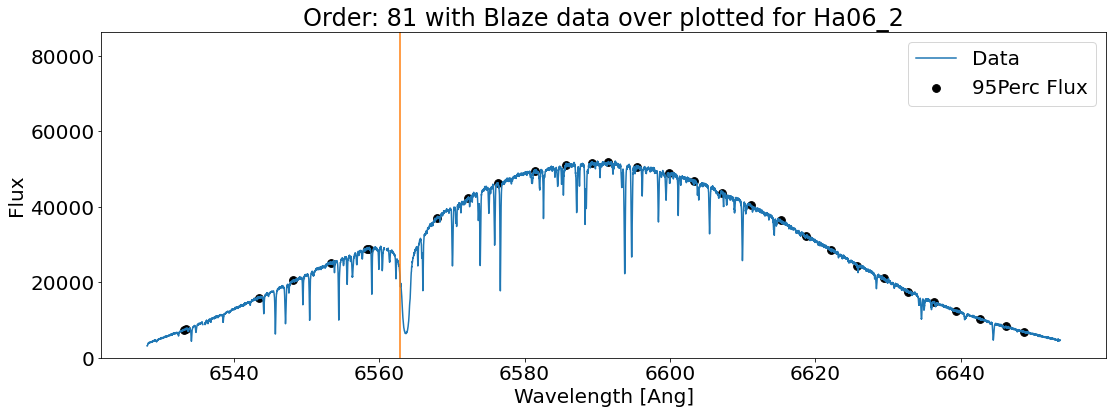

6528.063826962231

In [756]:
# Plot the order, with the blaze function dots overplotted, and location of line of interest
plotme=1
if plotme == 1:
   plt.plot(sci_wave_ord,sci_flux_ord,label='Data')    
   plt.scatter(db_wl_values,db_fl_values,color = 'black',label='95Perc Flux',s=60)
   plt.plot([line_center,line_center],[0,1e6])
   plt.title("Order: "+ str(order)+' with Blaze data over plotted for '+line_name)
   plt.xlabel('Wavelength [Ang]')
   plt.ylabel('Flux')
   plt.ylim(0,np.median(db_fl_values)*3)
   plt.legend()
   plt.show()
sci_wave_ord[0]

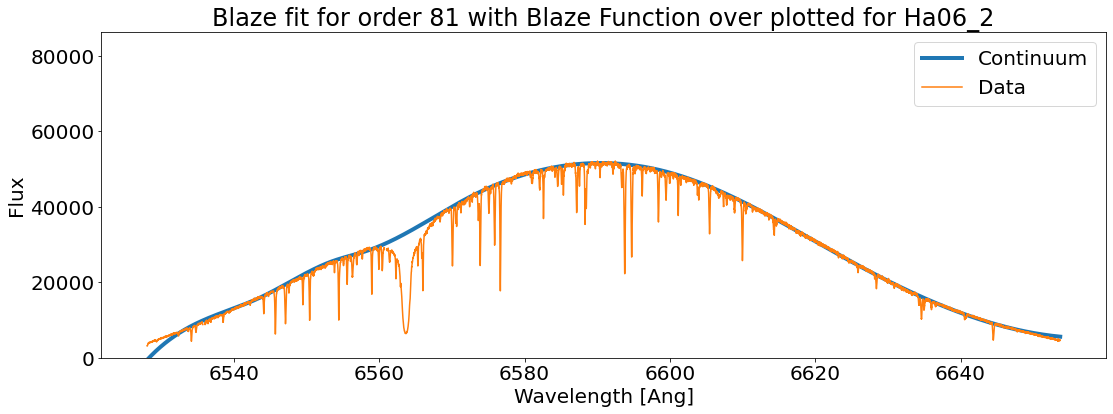

In [757]:
# Overplot the blaze function
plotme=1
if plotme == 1:
   plt.plot(sci_wave_ord,flux_fit,label='Continuum',linewidth=4)
   plt.plot(sci_wave_ord,sci_flux_ord,label='Data')
   plt.xlabel('Wavelength [Ang]')
   plt.ylabel('Flux')
   plt.title("Blaze fit for order "+ str(order)+' with Blaze Function over plotted for '+line_name)
   plt.ylim(0,np.median(db_fl_values)*3)
   plt.legend()
#   print(len(wl_values),len(fl_values))

In [758]:
# Use the radial velocity (systemic and BC) from the header to shift to the rest frame
# For KPF, the Earth reference frame will be written into the L1 files.

# 15Feb2022: The wavelength is not in the rest frame, so this step is still necessary.

# shift the wavelength by the BC.
print("BC value (km/s):",bc_ord_rv)
delta_lambda_bc = bc_ord_rv * line_center / c_kmps.to_value()
print("Wavelength shift [Ang]",delta_lambda_bc)

# ATTENTION: Find better way to determine ord_delta_lambda
mid_pix = round(npix/2.)
ord_delta_lambda = sci_wave_ord[mid_pix]-sci_wave_ord[mid_pix-1] # choose delta_lambda at beginning of order.
delta_pix_bc = delta_lambda_bc / (ord_delta_lambda)
print("BC Shift in pixels: ",delta_pix_bc)


# This is currently a kludge until I understand the wavelength solution  in the header

systemic_rv = 55 # systemic RV, Is it in the header? guess for now. **********
# Why is such a large value required? Should be 16.8 km/s

delta_lambda_sys = systemic_rv * line_center / c_kmps.to_value()
delta_pix_sys = delta_lambda_sys / (ord_delta_lambda)
print("Systemic Shift in pixels: ",delta_pix_sys)

sci_wave_rest = shift(sci_wave_ord,(delta_pix_bc+delta_pix_sys), cval=0) #ATTENTION: setting values to 0.

# Set the value from outside the array to Nan, shift is a pixel shift, not value shift.
# print("Orig wavelength 0,-1 pixel:",sci_wave_rest[0],sci_wave_ord[-2])
# print("Shifted wavelength 0,-1 pixel:",sci_wave_rest[0],sci_wave_rest[-2])

BC value (km/s): -22.84111582691802
Wavelength shift [Ang] -0.500018775248256
BC Shift in pixels:  -36.74799942999553
Systemic Shift in pixels:  88.48691911398923


In [759]:
# Large cosmics are problematic. Replace with nearby median
# Todo: Need to mask out the line core.

norm_ord_flux_no_nas = np.nan_to_num(flux_norm,nan=1)  # remove NaN values
thresh = 1.2 * np.median(norm_ord_flux_no_nas)         # 1.2 * median flux is in continuum sections

for i,item in enumerate(flux_norm):
    if i > 5 and i < npix-6: # beware of edges
        if item > thresh:
            norm_ord_flux_no_nas[i] = np.median([norm_ord_flux_no_nas[i-5],norm_ord_flux_no_nas[i+5]]) # replace with median of surrounding pixels
#print("Threshold:",thresh)


Text(0, 0.5, 'Normalized Flux')

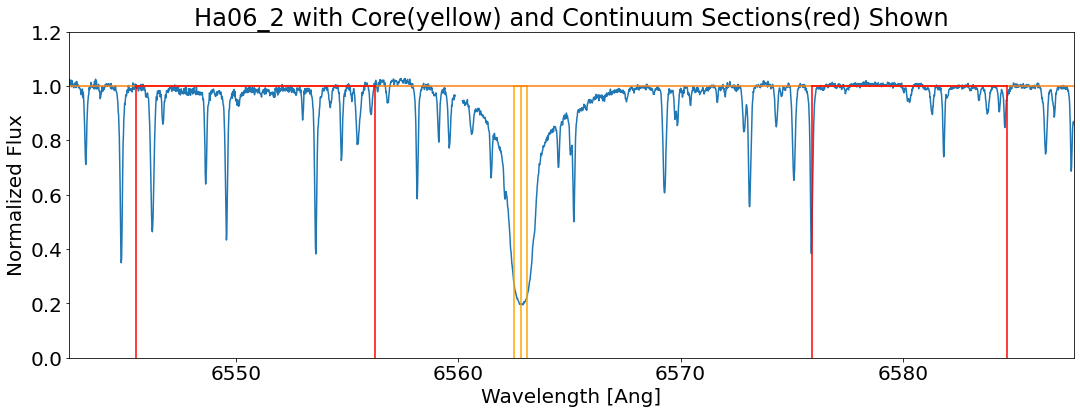

In [760]:
# Plot the normalized - deblazed - shifted spectrum.  Overplot the line window and continuum windows.

plt.plot(sci_wave_rest,flux_norm)
plt.plot([line_center,line_center],[0,1.0],c='orange')
plt.plot([line_wid1a ,line_wid1a],[0,1.0],c='orange')
plt.plot([line_wid1b,line_wid1b],[0,1.0],c='orange')
plt.plot([line_wid1a,line_wid1b],[1.0,1.0],c='orange')
plt.plot([lambda_c1a-3,lambda_c2b+3],[1,1])

plt.plot([lambda_c1a,lambda_c1b],[1.0,1.0],c='red')
plt.plot([lambda_c2a,lambda_c2b],[1.0,1.0],c='red')
plt.plot([lambda_c1a,lambda_c1a],[0,1.0],c='red')
plt.plot([lambda_c1b,lambda_c1b],[0,1.0],c='red')
plt.plot([lambda_c2a,lambda_c2a],[0,1.0],c='red')
plt.plot([lambda_c2b,lambda_c2b],[0,1.0],c='red')

plt.xlim([lambda_c1a-3,lambda_c2b+3])
plt.ylim(0.,1.2)
plt.title(line_name + " with Core(yellow) and Continuum Sections(red) Shown")
plt.xlabel('Wavelength [Ang]')
plt.ylabel('Normalized Flux')


In [761]:
# Calculate the flux in line centers and reference bands
# For H-alpha this is based on Kurster 2003 and Gomes da Silva 2011 as referenced in Robertson 2013

condition1 = (sci_wave_rest > line_wid1a) & (sci_wave_rest < line_wid1b )
condition2 = (sci_wave_rest > lambda_c1a) & (sci_wave_rest < lambda_c1b)
condition3 = (sci_wave_rest > lambda_c2a) & (sci_wave_rest < lambda_c2b)

# Use extract to get the elements that satisfy the above conditions
line_flux = np.sum(np.extract(condition1,flux_norm))
cont1_flux  = np.sum(np.extract(condition2,flux_norm))
cont2_flux  = np.sum(np.extract(condition3,flux_norm))

# Calculate poisson errros on the sections
line_flux_p = np.sum(np.extract(condition1,sci_flux_ord))
cont1_flux_p  = np.sum(np.extract(condition2,sci_flux_ord))
cont2_flux_p  = np.sum(np.extract(condition3,sci_flux_ord))


line_metric = line_flux / (  (cont1_flux + cont2_flux)  )
#I_Halpha = flux_Halpha / (flux_cont1 + flux_cont2) # Is there a factor of 2 involved?
# K2003 uses the average flux of the cont sections. Not obvious that Roberston does this.

print("Line metric:             ",line_metric) #flux_Halpha, flux_cont1,flux_cont2,I_Halpha)

print('Npix in Core, Cont1, Cont2:', condition1.sum(), condition2.sum(),condition3.sum())
# condition1.sum() # sum True in a boolean

Line metric:              0.006821299683867392
Npix in Core, Cont1, Cont2: 38 648 588


In [762]:
#Calculate the errors:
# R2013, eqn 2. "we multiplied the rms in the continuum in the 0.5 Å adjacent to the Hα or Ca i line by √N ,
#        where N is the number of pixels in the line (i.e., σ_FHα = rms_{FHα±0.5} × √N ). 
# Linke to H-alpha paper, use equation 2: https://iopscience.iop.org/article/10.1088/0004-637X/764/1/3/pdf

# line flux error
line_flux_error = np.std(np.extract(condition1,flux_norm)) * np.sqrt(condition1.sum())
cont1_flux_error = np.std(np.extract(condition2,flux_norm)) * np.sqrt(condition2.sum())
cont2_flux_error = np.std(np.extract(condition3,flux_norm)) * np.sqrt(condition3.sum())
    
line_flux_error,cont1_flux_error  
line_metric_error = line_flux  * np.sqrt(  (line_flux_error/np.sum(line_flux_p))**2 + 
                                          ( (np.sqrt(cont1_flux_error**2 + cont2_flux_error**2)) 
                                             / (cont1_flux_p + cont2_flux_p) ))

# Insert the values into the arrays that will fill the columns for the activiy binTable
line_values[ind] = line_metric
line_errors[ind] = line_metric_error

#insert into columns for BINTable
c2.array = line_values
c3.array = line_errors

0.0020060108121868177

In [765]:
# Create the BinTableHDU that will be put into an old NEID or KPF file. Based on Activity table from recen NEID obs.

# Create a new BinTable from the columns, overwrite the old one.
Activity_new = fits.BinTableHDU.from_columns([c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11],name='Activity2')

# #This is where we could open the file and save the table.
# with fits.open(TEST_DIR + in_file) as hdul2:
# #    hdul2.info()
# #    hdul2['ACTIVITY'] = tbhdu
#     hdul2.pop('Activity')
#     hdul2.append(Activity_new)

Activity_new.data

FITS_rec([('HeI_1', '0.0', '0.0', '5875.62', 0, 5869, 5881,  5,  5, '68', ''),
          ('HeI_2', '0.0', '0.0', '5875.62', 0, 5869, 5881,  5,  5, '69', ''),
          ('NaI', '0.0', '0.0', '5895.92, 5889.95', 0, 5805, 6097, 10, 20, '67, 69, 72', ''),
          ('Ha06_1', '0.0', '0.0', '6562.808', 0, 6550, 6580, 10,  8, '79', ''),
          ('Ha06_2', '0.00682129', '0.00200601', '6562.808', 0, 6550, 6580, 10,  8, '80', ''),
          ('Ha16_1', '0.0', '0.0', '6562.808', 1, 6550, 6580, 10,  8, '79', ''),
          ('Ha16_2', '0.0', '0.0', '6562.808', 1, 6550, 6580, 10,  8, '80', ''),
          ('CaI_1', '0.0', '0.0', '6572.795', 0, 6550, 6580, 10,  8, '79', ''),
          ('CaI_2', '0.0', '0.0', '6572.795', 0, 6550, 6580, 10,  8, '80', ''),
          ('CaIRT1', '0.0', '0.0', '8498.018', 0, 8492, 8504,  2,  2, '101', ''),
          ('CaIRT2', '0.0', '0.0', '8542.089', 0, 8534, 8550,  2,  2, '101', ''),
          ('CaIRT3', '0.0', '0.0', '8662.14', 0, 8654, 8669,  2,  2, '102', ''),
     

I suppose the order of the functions would be something like:
    - Set all standard variables. (done)
    - Open the spectrum (done)
    - Identify the order and wavelength solution (done)
    - Deblaze the order (done)
    - Remove outliers in flux (done)
    - If necessary, shift the wavelength solutin accordingly. (done)
    - Measure the flux. (done)
    - Format the HDU table that will hold the flux values. (done)